# Abalone Rings Regression Prediction

This notebook is focused on analyzing features from abalone to be able to predict the amount of rings. Since rings correspond to age, this is a regression task for predicting the age of abalone.

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

In [3]:
df = pd.read_csv('abalone.csv')
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Basic data info prior to splitting into train/test

In [4]:
df.info() # no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [5]:
df.duplicated().unique() # no duplicates

array([False])

In [6]:
df.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
Length,4177.0,0.523992,0.120093,0.0750,0.4500,0.5450,0.615,0.8150
Diameter,4177.0,0.407881,0.099240,0.0550,0.3500,0.4250,0.480,0.6500
Height,4177.0,0.139516,0.041827,0.0000,0.1150,0.1400,0.165,1.1300
Whole weight,4177.0,0.828742,0.490389,0.0020,0.4415,0.7995,1.153,2.8255
Shucked weight,4177.0,0.359367,0.221963,0.0010,0.1860,0.3360,0.502,1.4880
Viscera weight,4177.0,0.180594,0.109614,0.0005,0.0935,0.1710,0.253,0.7600
Shell weight,4177.0,0.238831,0.139203,0.0015,0.1300,0.2340,0.329,1.0050
Rings,4177.0,9.933684,3.224169,1.0000,8.0000,9.0000,11.000,29.0000


In [7]:
# Only non-number column is "sex"

df['Sex'].value_counts()

M    1528
I    1342
F    1307
Name: Sex, dtype: int64

The only data that is alarming (initially) is the minimum height value is 0. I will explore this data first.

In [8]:
zero_height = df[df['Height']<0.03].sort_values(by='Height')

zero_height

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,0.430,0.340,0.000,0.4280,0.2065,0.0860,0.1150,8
3996,I,0.315,0.230,0.000,0.1340,0.0575,0.0285,0.3505,6
236,I,0.075,0.055,0.010,0.0020,0.0010,0.0005,0.0015,1
1174,F,0.635,0.495,0.015,1.1565,0.5115,0.3080,0.2885,9
2169,I,0.165,0.115,0.015,0.0145,0.0055,0.0030,0.0050,4
694,I,0.165,0.110,0.020,0.0190,0.0065,0.0025,0.0050,4
3902,I,0.160,0.120,0.020,0.0180,0.0075,0.0045,0.0050,4
719,I,0.150,0.100,0.025,0.0150,0.0045,0.0040,0.0050,2
720,I,0.160,0.110,0.025,0.0180,0.0065,0.0055,0.0050,3
1987,I,0.160,0.110,0.025,0.0195,0.0075,0.0050,0.0060,4


In looking at the data above, it seems like there is a possibility this could be an issue of rounding. The data seems to be precise to 0.005, so 0.000 could be rounded down. I will leave it alone as rounding is part of the convention.

Another piece of data to look at is to compare whole weight to the sum of the shucked, viscera, and shell weight.

<ipython-input-9-89385ee958ce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weight['sum of weight'] = df_weight['Shucked weight'] + df_weight['Viscera weight'] + df_weight['Shell weight']
<ipython-input-9-89385ee958ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weight['diff'] = df_weight['Whole weight'] - df_weight['sum of weight']


<AxesSubplot:xlabel='diff', ylabel='Count'>

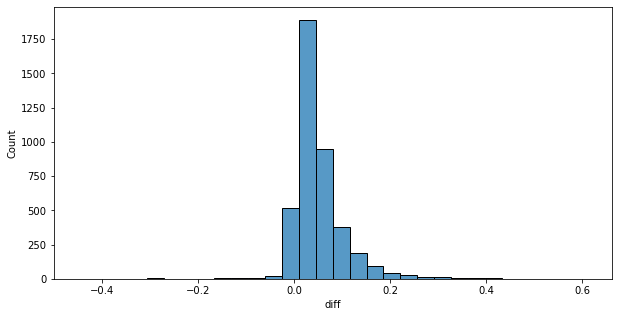

In [9]:
df_copy = df.copy()
df_weight = df_copy[['Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']]

# add sum column to compare
df_weight['sum of weight'] = df_weight['Shucked weight'] + df_weight['Viscera weight'] + df_weight['Shell weight']

# difference of sum to whole weight
df_weight['diff'] = df_weight['Whole weight'] - df_weight['sum of weight']

# histogram of differences
plt.figure(figsize=(10,5))
sns.histplot(data=df_weight, x='diff', bins=30)

By the definitions of the weights, it should be that whole weight >= the sum, thus the diff column above should not contain negative values. However, the individual weights could have some overlapping due to not getting the abalone perfectly cleaned. I will see how many have a negative diff

In [10]:
neg_diff = df_weight[df_weight['diff']<0]

neg_diff.describe()['diff']

count    1.550000e+02
mean    -4.436129e-02
std      8.478928e-02
min     -4.475000e-01
25%     -3.025000e-02
50%     -1.100000e-02
75%     -4.250000e-03
max     -6.938894e-18
Name: diff, dtype: float64

The data above shows that only 25% of the weight differences are < -0.03, which is about 25%. Given that this is a small error relative to the minimum (-0.44) and the weights overall, I will not keep the data which the weight difference is < -0.05, as that some error is to be expected since they have to be cleaned by a human, but anything lower was not done carefully enough.

In [11]:
df_to_remove = neg_diff[neg_diff['diff']<-0.05]

idx_to_remove = df_to_remove.index

df.drop(idx_to_remove, axis=0, inplace=True)

In [12]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [13]:
df.shape

(4146, 9)

Since none of the other columns are dependent on one another or have zero values, the only thing left to look at will be any outliers. This only needs to be done for numerical columns.

In [14]:
num_cols = df.select_dtypes(exclude='object').columns
obj_cols = df.select_dtypes(include='object').columns

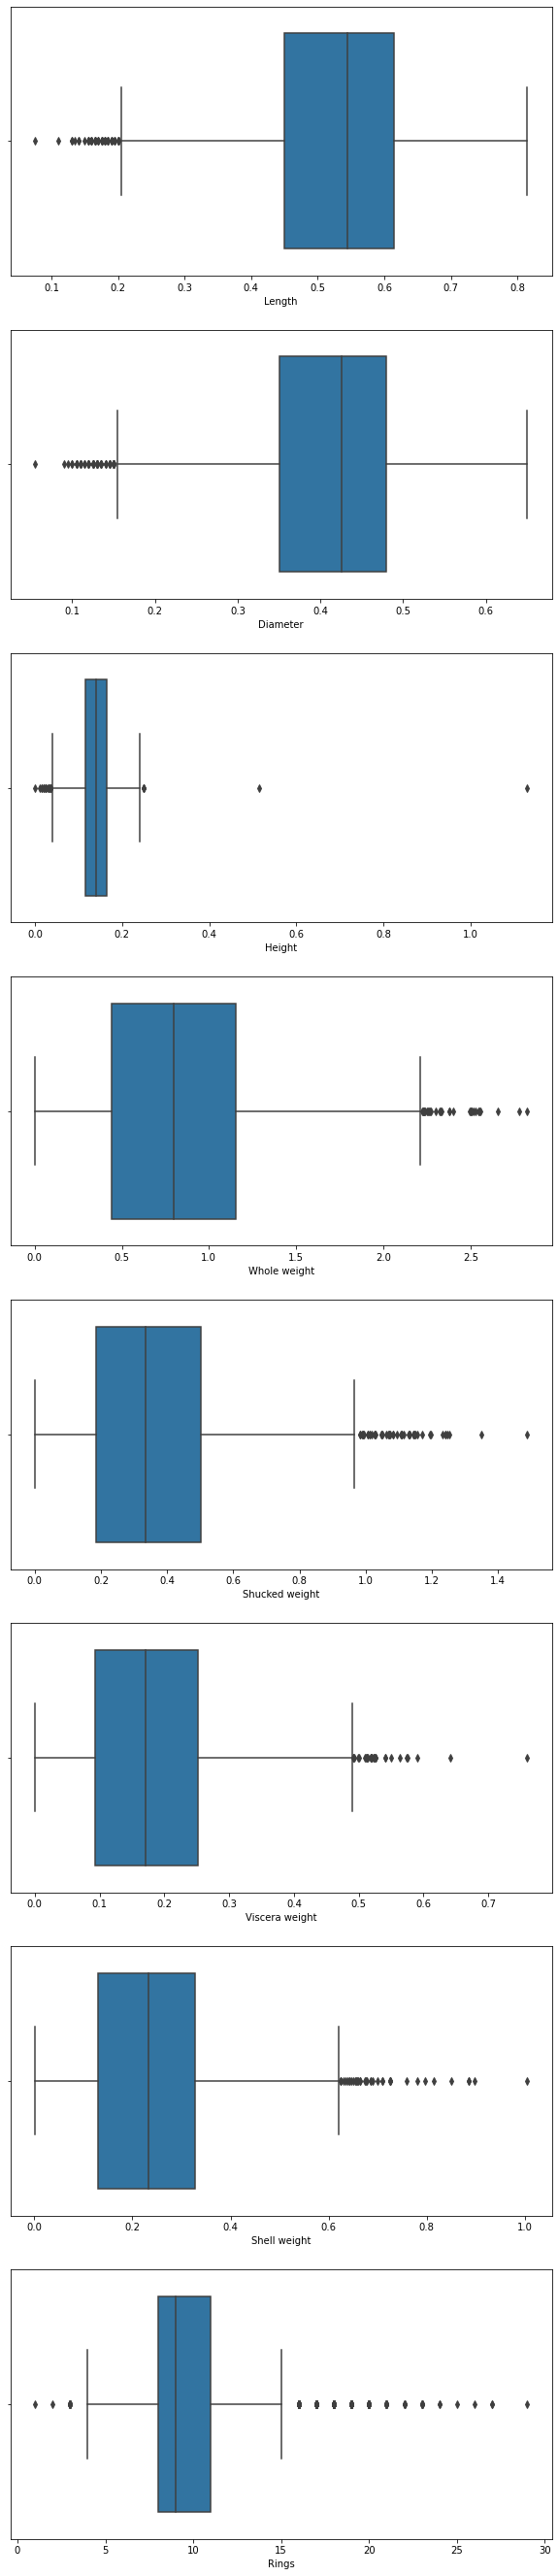

In [15]:
N = len(num_cols)

fig, ax = plt.subplots(nrows=N, ncols=1, figsize=(10, 6*N))

for i in range(N):
    sns.boxplot(data=df, x=num_cols[i], ax=ax[i])

While there are plenty of outliers in the above boxplots, only one feature stands out by having a couple extreme outliers, the height feature. I will look into these two points.

In [16]:
large_height = df[df['Height']>0.4]

large_height

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1417,M,0.705,0.565,0.515,2.210,1.1075,0.4865,0.5120,10
2051,F,0.455,0.355,1.130,0.594,0.3320,0.1160,0.1335,8


Compare this to the overall data to see if the measurements seem off

In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Length,4146.0,0.523999,0.119956,0.0750,0.4500,0.54500,0.615000,0.8150
Diameter,4146.0,0.407899,0.099117,0.0550,0.3500,0.42500,0.480000,0.6500
Height,4146.0,0.139512,0.041739,0.0000,0.1150,0.14000,0.165000,1.1300
Whole weight,4146.0,0.829427,0.489875,0.0020,0.4425,0.80025,1.153000,2.8255
Shucked weight,4146.0,0.358758,0.221048,0.0010,0.1860,0.33550,0.501500,1.4880
Viscera weight,4146.0,0.180463,0.109321,0.0005,0.0935,0.17100,0.252500,0.7600
Shell weight,4146.0,0.238565,0.139048,0.0015,0.1300,0.23350,0.327375,1.0050
Rings,4146.0,9.943560,3.229269,1.0000,8.0000,9.00000,11.000000,29.0000


The second data point (index 2051) has height over twice the first (which is the second largest overall), but all the other data has values below average: length, diameter, and all the weights. It is possible that a decimal point was missed. However, I am going to simply remove this from the dataset as there is a strong chance of some error.

In [19]:
df.drop([2051], axis=0, inplace=True)

In [20]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [21]:
df.shape

(4145, 9)

In [22]:
df.reset_index(drop=True, inplace=True)

Now that the data is cleaned, I will split it into a train and test set and explore the training data in more depth.

# Convert into train and test set, then explore train data.

In [23]:
train, test = train_test_split(df, test_size=0.1, random_state=101)

# Exploratory Data Analysis

### Object data

I will first exlore the object data, which is a singular column "Sex", and how it compares to all the other data. Since all the other categories are numerical, visualizing with box plots seems like the best idea.

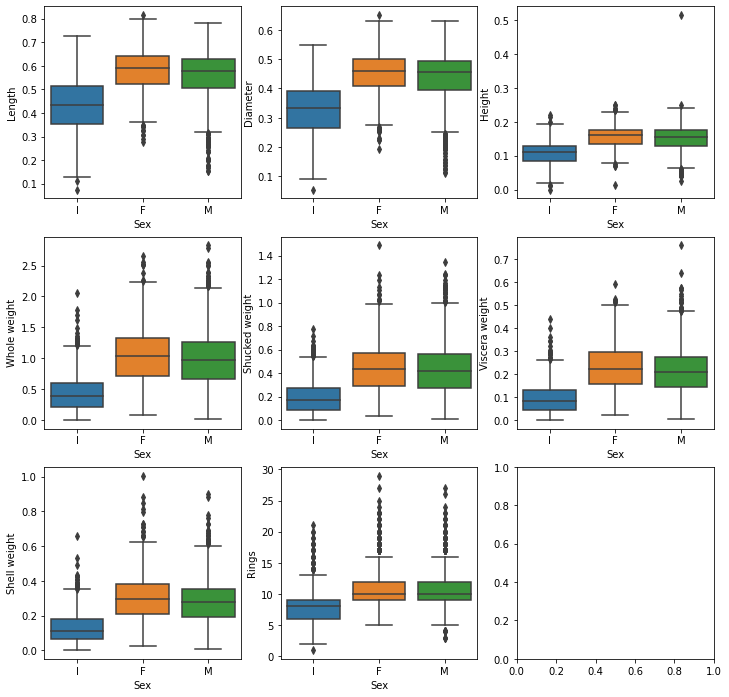

In [24]:
M_NUMS = len(num_cols)
M_OBJS = len(obj_cols)

M = M_NUMS * M_OBJS # number of boxplots needed

N_COLS = 3 # default the number of columns

counter = 0 # start the counter for keeping track of the ax for subplots

if M % 3 == 0:
    N_ROWS = M // 3
else:
    N_ROWS = M // 3 + 1
    
fig, ax = plt.subplots(figsize=(4*N_COLS, 4*N_ROWS), nrows=N_ROWS, ncols=N_COLS)

for i in range(M_OBJS):
    for j in range(M_NUMS):
        ROW = counter // N_COLS
        COL = counter % N_COLS
        if N_ROWS > 1:
            sns.boxplot(data=train, x=obj_cols[i], y=num_cols[j], ax=ax[ROW][COL])
        else:
            sns.boxplot(data=train, x=obj_cols[i], y=num_cols[j], ax=ax[counter])
        counter += 1 


The above does show very similar distributions for the Sex of F and M compared to each other category. I will look at the numbers more specifically to see if there is any obvious differences I cannot see from the plots above.

In [25]:
mean_df = train.groupby('Sex').mean().transpose()[['F', 'M']]

mean_df['diff'] = mean_df['F'] - mean_df['M']

mean_df

Sex,F,M,diff
Length,0.578205,0.559679,0.018526
Diameter,0.454351,0.438056,0.016294
Height,0.157173,0.150864,0.006309
Whole weight,1.045649,0.985536,0.060113
Shucked weight,0.444030,0.429628,0.014402
Viscera weight,0.229595,0.213407,0.016188
Shell weight,0.301868,0.280411,0.021458
Rings,11.175722,10.693654,0.482067


In [26]:
std_df = train.groupby('Sex').std().transpose()[['F', 'M']]

std_df['diff'] = std_df['F'] - std_df['M']

std_df

Sex,F,M,diff
Length,0.086088,0.103645,-0.017557
Diameter,0.070763,0.085401,-0.014638
Height,0.029940,0.035137,-0.005197
Whole weight,0.435843,0.469354,-0.033512
Shucked weight,0.199324,0.220954,-0.021630
Viscera weight,0.098037,0.104415,-0.006379
Shell weight,0.127524,0.131357,-0.003833
Rings,3.136464,3.020047,0.116417


With the similarities between M and F among all other categories, it seems like combining "F" and "M" into "A" (adult) as a single category for "Sex" will make the data simpler.

### Numerical Data

I will now explore the numerical data. There are many more columns (7), so there is more to explore here.

In [27]:
train_nums = train[num_cols]

train_nums.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
954,0.500,0.385,0.120,0.5600,0.2835,0.1030,0.1350,8
2443,0.500,0.385,0.130,0.7680,0.2625,0.0950,0.2700,13
768,0.530,0.455,0.165,0.9805,0.3155,0.2815,0.2965,11
884,0.675,0.525,0.155,1.4785,0.6280,0.3405,0.4200,9
3237,0.480,0.380,0.135,0.5280,0.2000,0.1395,0.1600,14


Since this is a regression task, I will first plot each category against the rings in a scatterplot to see if there is any strong correlations.

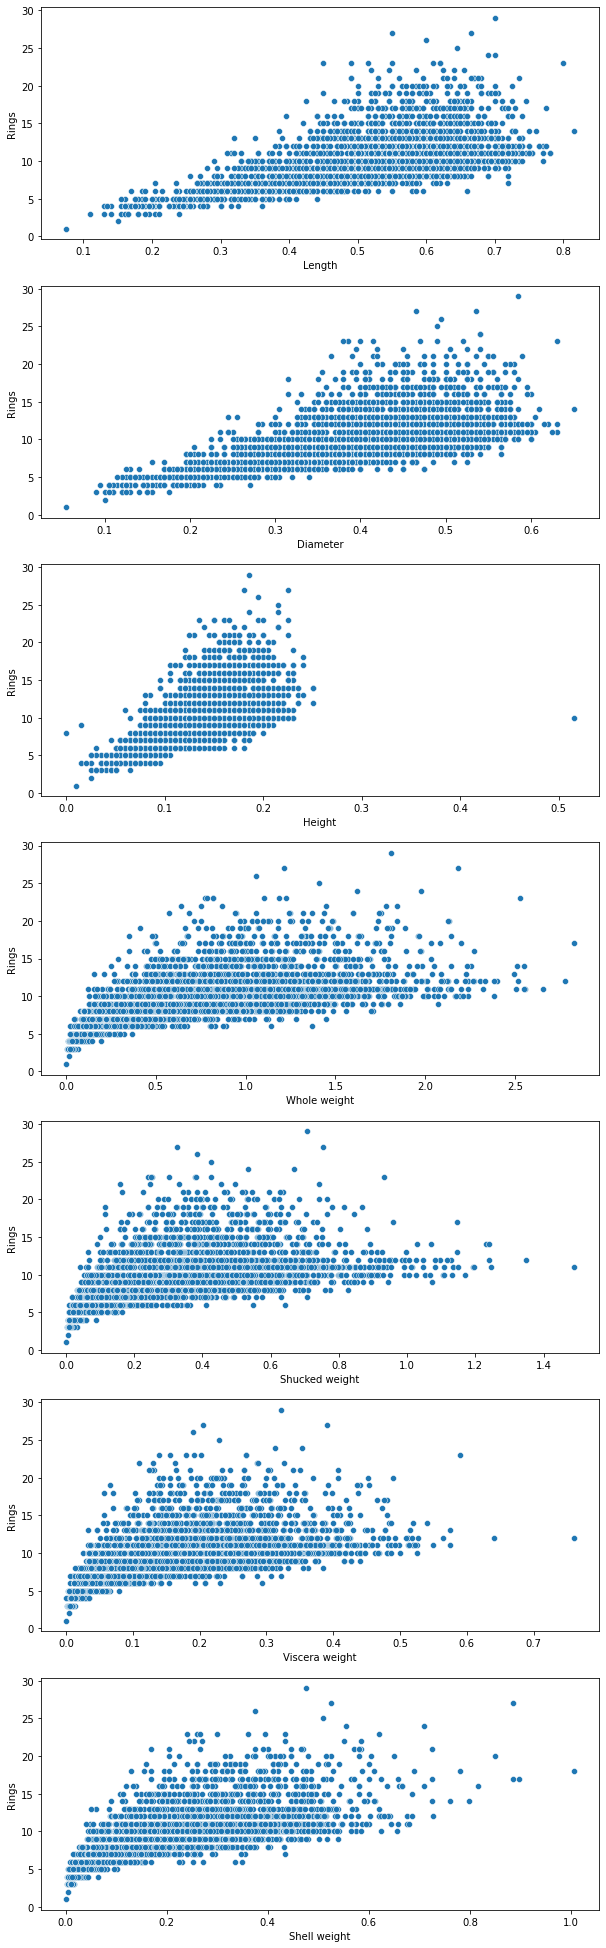

In [28]:
features = train_nums.columns.drop('Rings')

N = len(features)

fig, ax = plt.subplots(figsize=(10, 5*N), nrows=N, ncols=1)

for i in range(len(features)):
    sns.scatterplot(data=train_nums, x=features[i], y='Rings', ax=ax[i])

The above shows there is a lack of correlation. Overall, the number of rings goes up as each of the categories goes up, however, I can see that the variance is quite large. I will check the correlations to see.

<AxesSubplot:>

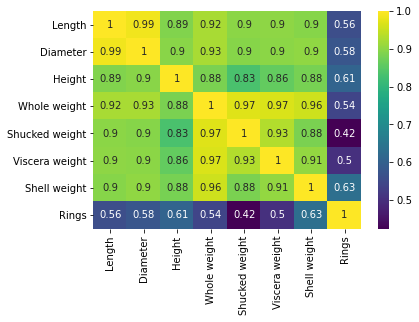

In [29]:
sns.heatmap(data=train_nums.corr(), annot=True, cmap='viridis')

# We see some of the categories are highly correlated, which we will take a note of.

The above confirms what we observed. All correlations with the "Rings" category are positive, but ~0.5 for each category. Indicating that a simple linear model may not produce good results.

I will now look at the pairplot to see if there is another level here.

<Figure size 1080x1080 with 0 Axes>

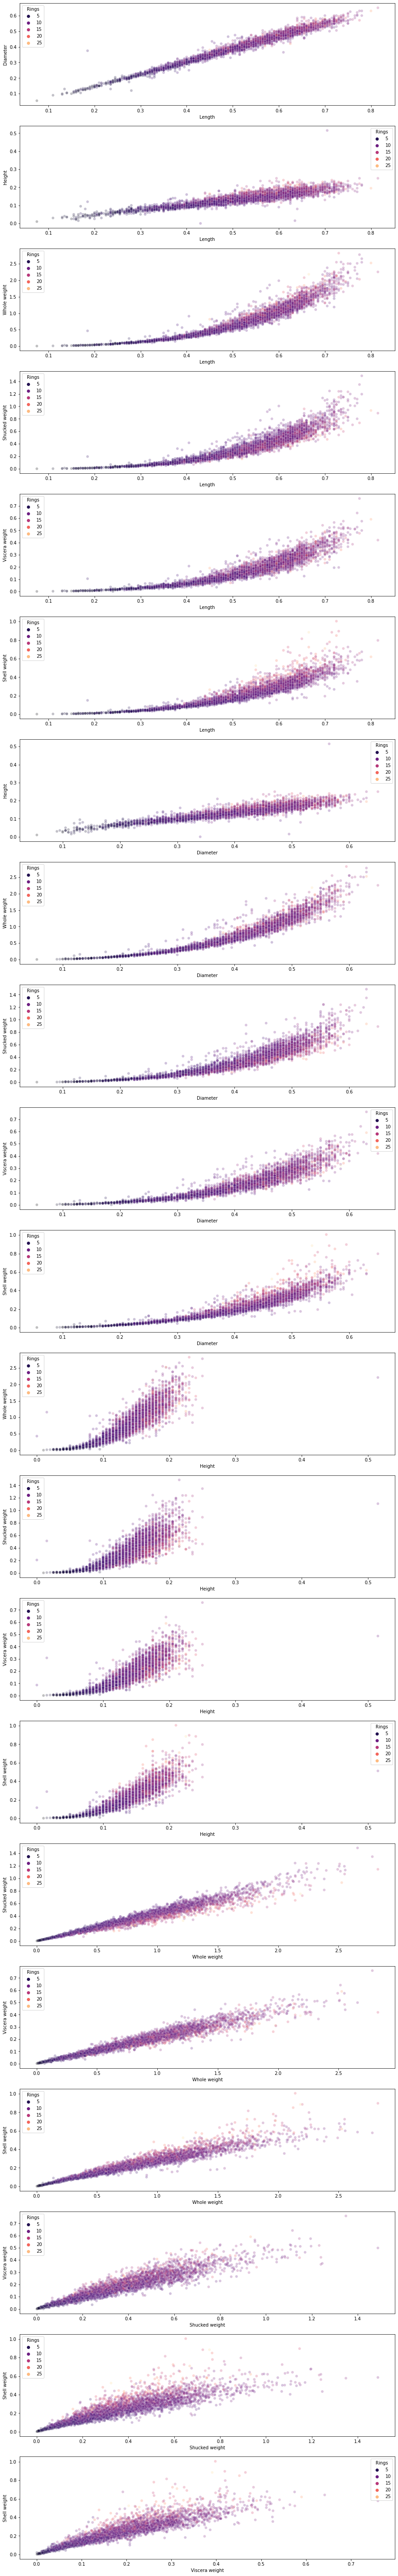

In [30]:
plt.figure(figsize=(15, 15))
# If there are M pairs, then the amount of unique combinations
# is sum(1,M-1) = M*(M-1)/2

M = len(features)
N = M*(M-1)//2 # guaranteed integer
N_COLS = 1
if N % N_COLS == 0:
    N_ROWS = N // N_COLS
else:
    N_ROWS = N // N_COLS + 1
    
overall_counter = 0
    
fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, 5*N_ROWS))

for i in range(M):
    j = i+1
    while j < M:
        N_ROW = overall_counter // N_COLS
        N_COL = overall_counter % N_COLS
        if N_COLS != 1:
            sns.scatterplot(data=train_nums, 
                            x=features[i], 
                            y=features[j], 
                            ax=ax[N_ROW, N_COL], 
                            hue='Rings', 
                            palette='magma', 
                            alpha=0.25)
        else:
            sns.scatterplot(data=train_nums, 
                            x=features[i], 
                            y=features[j], 
                            ax=ax[overall_counter], 
                            hue='Rings', 
                            palette='magma', 
                            alpha=0.25)            
        j += 1
        overall_counter += 1

When comparing two features against the number of rings, I still see that the number of rings increases as the features increase, but in a not clear way. Specifically, we can see that some of the points having ten rings in the "Shell weight vs Viscera weight" have large of both features than plenty of the points with 20 rings. To alleviate try to gain on a potential prediction, it could be useful to add features, specifically interaction terms of the numerical categories.

Overall, this would indicate that I should not expect a model to do incredibly well. Since the average amount of rings ~10, expecting an RMSE of <1 (10%) seems unlikely.

I will create new columns with new features from the polynomial features function and look at the ratios of the numerical columns as well. I will then train using XGBoostRegressor to see what the feature importance scores are to see if any stick out.

# Transform the data

I will now create classes to transform the data to be used for the model. Note that the above indicates that using polynomial features may turn out to be helpful.



In [31]:
X_train = train.drop('Rings', axis=1)
y_train = train['Rings']

X_test = test.drop('Rings', axis=1)
y_test = test['Rings']

X = df.drop('Rings', axis=1)
y = df['Rings']

In [32]:
### Add attributes to the data for the numerical_data

scaler = StandardScaler()
enc = OneHotEncoder()
poly = PolynomialFeatures(degree=2, include_bias=False)

class RatioNumericalAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
       # Return ratios. Note: Since Height is the only num feature to be zero,
       # I will make sure it is not in the denominator.
        X_num_feats = X.select_dtypes(exclude='object').columns
        X_num_feats_no_zero = X_num_feats.drop('Height')
        pairs = [] # keep track of the ratios to add
        X_trans = X.copy() # make a copy to return
        for x in X_num_feats:
            for y in X_num_feats_no_zero:
                if y != x and (x,y) not in pairs and (y,x) not in pairs:
                    pairs.append((x,y))
        
        for i in range(len(pairs)):
            num = pairs[i][0] # num feature
            denom = pairs[i][1] # denom feature
            feat_name = f'{num}_over_{denom}'
            X_trans[feat_name] = X_trans[num] / X_trans[denom]
        
        
        return X_trans
        
    def get_feature_names(self, X):
        return X_trans.columns
    
### Apply standard Scaler after CombinedNumericalAttributesAdder to numerical data

nums = Pipeline([
    ('ratios', RatioNumericalAttributesAdder()), # do ratios first
    ('scaler', scaler) # then scale the data
])

### Categorical Transformations

# Change M + F to A for the "Sex" feature, then OneHotEncode
class SexCategorySimplifier(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        N = X.shape[0]
        X_trans = X.copy()
        
        for i in range(N):
            curr_idx = X_trans.index[i]
            if X_trans.loc[curr_idx, 'Sex'] == 'I':
                continue
            else:
                X_trans.loc[curr_idx, 'Sex'] = 'A'
        return X_trans
    
objs = Pipeline([
    ('sex', SexCategorySimplifier()),
    ('enc', enc)
])

# Transform them into one
preprocessing = ColumnTransformer([
    ('nums', nums, X.select_dtypes(exclude='object').columns),
    ('objs', objs, X.select_dtypes(include='object').columns),
])

In [33]:
### Helper function to put in a model and output the information of the fitted model
def model_fit_and_scores(grid, X, y):
    """
    Fit a model to X and y using a gridsearchCV with param grid.
    Return the model, model's best params, 5 best scores.
    """
    grid.fit(X,y)
    best_params = grid.best_params_
    best_scores = np.sort(grid.cv_results_['mean_test_score'])[::-1][:5]
    best_scores = [np.sqrt(-x) for x in best_scores]
    return grid, best_params, best_scores

## Setup first model: SGDRegressor

In [34]:
sgd = SGDRegressor(max_iter=10000, random_state=42) # Define the model

### Pipeline

sgd_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('sgd', sgd)
])


### sgd param_grid

sgd_param_grid = {
    'sgd__loss': ['huber'],
    'sgd__epsilon': [2, 0.5, 1],
    'sgd__penalty': ['l1'],
    'sgd__alpha': [0.0009, 0.001, 0.0015],
    'sgd__learning_rate': ['optimal']
}

### grid search
sgd_grid = GridSearchCV(estimator=sgd_pipeline, 
                        param_grid = sgd_param_grid, 
                        cv=5, 
                        scoring='neg_mean_squared_error', 
                        verbose=2)

In [35]:
sgd_model, sgd_params, sgd_best_scores = model_fit_and_scores(sgd_grid, X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END sgd__alpha=0.0009, sgd__epsilon=2, sgd__learning_rate=optimal, sgd__loss=huber, sgd__penalty=l1; total time=   0.3s
[CV] END sgd__alpha=0.0009, sgd__epsilon=2, sgd__learning_rate=optimal, sgd__loss=huber, sgd__penalty=l1; total time=   0.3s
[CV] END sgd__alpha=0.0009, sgd__epsilon=2, sgd__learning_rate=optimal, sgd__loss=huber, sgd__penalty=l1; total time=   0.3s
[CV] END sgd__alpha=0.0009, sgd__epsilon=2, sgd__learning_rate=optimal, sgd__loss=huber, sgd__penalty=l1; total time=   0.3s
[CV] END sgd__alpha=0.0009, sgd__epsilon=2, sgd__learning_rate=optimal, sgd__loss=huber, sgd__penalty=l1; total time=   0.3s
[CV] END sgd__alpha=0.0009, sgd__epsilon=0.5, sgd__learning_rate=optimal, sgd__loss=huber, sgd__penalty=l1; total time=   0.3s
[CV] END sgd__alpha=0.0009, sgd__epsilon=0.5, sgd__learning_rate=optimal, sgd__loss=huber, sgd__penalty=l1; total time=   0.3s
[CV] END sgd__alpha=0.0009, sgd__epsilon=0.5, sgd__learning_r

In [36]:
print(f'The model is: {sgd_model.best_estimator_[1]}. \n\n'
      f'The best params are: {sgd_params} and its five best rmse validation scores of {sgd_best_scores}.')

The model is: SGDRegressor(alpha=0.001, epsilon=1, learning_rate='optimal', loss='huber',
             max_iter=10000, penalty='l1', random_state=42). 

The best params are: {'sgd__alpha': 0.001, 'sgd__epsilon': 1, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'huber', 'sgd__penalty': 'l1'} and its five best rmse validation scores of [2.164646066155936, 2.1667337804980016, 2.1717543106191344, 2.174925715681401, 2.1799715016249253].


The above shows adding in these extra features makes extremely small improvements. I can see if any of the new features had non-zero coefficients.

In [43]:
### cols is the feature names

X_train_trans = RatioNumericalAttributesAdder().transform(X_train.select_dtypes(exclude='object'))

cols = X_train_trans.columns.tolist()

X_train_trans_objs = objs.fit_transform(X_train.select_dtypes(include='object'))

obj_cols = objs['enc'].get_feature_names().tolist()

cols.extend(obj_cols)

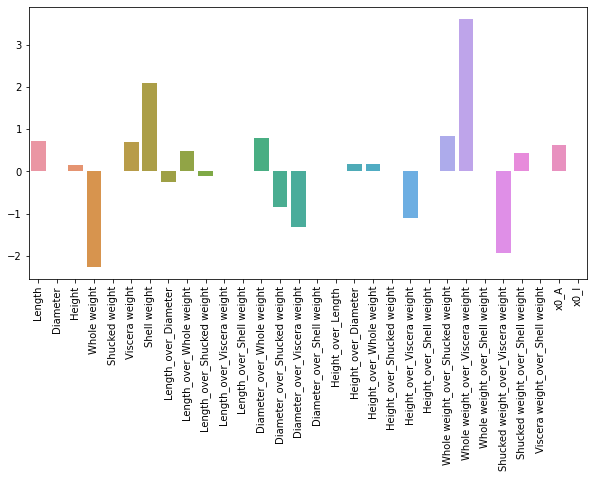

In [46]:
coefs = sgd_model.best_estimator_[1].coef_ # coefficients

features = cols

coefs_series = pd.Series(index=features, data=coefs)


### Create visual of coefs
plt.figure(figsize=(10,5))
sns.barplot(x=coefs_series.index, y=coefs_series.values)

plt.xticks(rotation=90)

plt.show()

As I can see, many of the features are non-zero when an l1 regularization is applied. Thus, I will keep the transformation for the ratios.

After doing many grid searches on many models, including SVR, KNNRegressor, and XGBRegressor, it was obvious that there was no major improvement for any of the different models once finding ideal hyperparameters. Thus, due to interpretability, I decided to remain with the SGDRegressor model above.

Note: Overall, the best RMSE for each model was around 2.1-2.2 and MAE was around 1.4-1.5 for each. Since the model is predicting an integer value (rings), it does not seem useful to find the model that minimizes the validation error, since the models are outputting such similar values, and the test scores for the slightly "better" model (based on validation score) could end up having a worse score on the holdout set.

In [104]:
### Predict on the test set and get some metrics
preds = sgd_model.predict(X_test)

### rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))

### mae
mae = mean_absolute_error(y_test, preds)


print(f'For the final SGD model, predicting on the holdout set gives RMSE of {rmse} and MAE of {mae}.')

For the final SGD model, predicting on the holdout set gives RMSE of 2.099797799011114 and MAE of 1.5249461850399284.


Because the model is performing as expected on the hold-out set, I will retrain the model on the entirety of X,y to get the final model.

In [105]:
final_sgd = SGDRegressor(alpha=0.001, 
                           epsilon=1, 
                           learning_rate='optimal', 
                           loss='huber', max_iter=10000, 
                           penalty='l1', 
                           random_state=42)


final_model = Pipeline([
    ('preprocessing', preprocessing),
    ('final_sgd', final_sgd)
])

final_model.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('nums',
                                                  Pipeline(steps=[('ratios',
                                                                   RatioNumericalAttributesAdder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight'],
      dtype='object')),
                                                 ('objs',
                                                  Pipeline(steps=[('sex',
                                                                   SexCategorySimplifier()),
                                                                  ('enc',
                                                                   OneHotEnco

In [106]:
all_preds = final_model.predict(X)

all_rmse = np.sqrt(mean_squared_error(y, all_preds))
all_mae = mean_absolute_error(y, all_preds)

print(f'The final model has an RMSE of {all_rmse} and MAE of {all_mae} on the entirety of the cleaned df.')

The final model has an RMSE of 2.1287862339914088 and MAE of 1.5024402505325987 on the entirety of the cleaned df.


In [69]:
### Save the model

from joblib import dump, load

In [107]:
dump(final_model, 'FinalSGDModelAbalone.joblib')

['FinalSGDModelAbalone.joblib']

In [108]:
model = load('FinalSGDModelAbalone.joblib')

In [109]:
### make random predictions on the original data

rand_idx = np.random.randint(0, high=X.shape[0], size=25) # random indices

In [110]:
data_to_predict = X.loc[rand_idx]
y_values_for_data = y.loc[rand_idx]

sample_preds = model.predict(data_to_predict) # sample preds to compare

preds_df = pd.DataFrame(data=np.c_[y_values_for_data, sample_preds], columns=['True Value', 'Prediction'])

preds_df

,True Value,Prediction
0,10.0,11.722239
1,11.0,10.746642
2,8.0,9.026911
3,11.0,9.430906
4,10.0,9.317496
5,10.0,8.928626
6,6.0,9.790032
7,11.0,9.302007
8,6.0,6.484831
9,11.0,9.548589


In [111]:
sample_rmse = np.sqrt(mean_squared_error(y_values_for_data, sample_preds))
sample_mae = mean_absolute_error(y_values_for_data, sample_preds)

print(f'For the sample data, the RMSE is {sample_rmse} and MAE is {sample_mae}.')

For the sample data, the RMSE is 2.3365262337322794 and MAE is 1.6217683175294246.


An observation above from the sample data and predictions shows something that is probably not unexpected, but the errors seem to be much larger if the true value is farther away from the 5-12 range. I will relook at the statistics for the "Rings" to see if this is where most of the data lies.

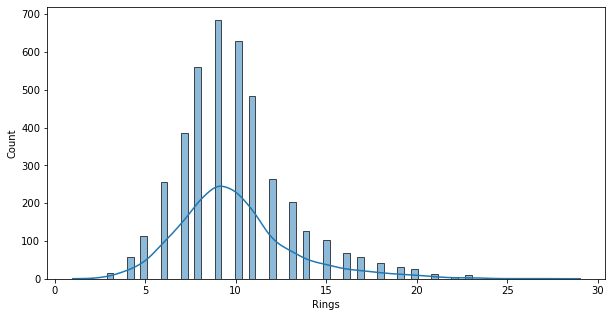

In [112]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Rings', kde=True)

plt.show()

In [113]:
df[df['Rings']<5].shape[0] # Number of sample with rings < 5

74

In [114]:
df[df['Rings']>13].shape[0] # Number of samples with rings > 13

490

Since there are not many with rings < 5, I will lump those together and break the dataframe into two: large and small rings, with the bound set at 14.

I will then see how these predictions compare to each other and the overall prediction

In [137]:
def predictions(df, model):
    """
    Using the given df, predict how the model
    performs on it, and return the RMSE and MAE.
    """
    X = df.drop('Rings', axis=1)
    y = df['Rings']
    
    preds = model.predict(X)
    
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    
    print(f'For the given df, the model predicts a RMSE of {rmse} and MAE of {mae}.')    

In [141]:
bound = 13

small_rings = df[df['Rings']<=bound]
large_rings = df[df['Rings']>bound]

predictions(small_rings, final_model) # small predictions first
predictions(large_rings, final_model) # Then large predictions
predictions(df, final_model) # overall score as a reminder

For the given df, the model predicts a RMSE of 1.5527025184094205 and MAE of 1.1862889123821347.
For the given df, the model predicts a RMSE of 4.511264633537007 and MAE of 3.860671150410039.
For the given df, the model predicts a RMSE of 2.1287862339914088 and MAE of 1.5024402505325987.


As the above shows, the model performs terribly if the number of rings is >13 with an RMSE of ~4.5 and MAE of ~ 3.9, whereas for the data with rings <=13, the model has an RMSE of ~1.55 and MAE of ~ 1.2.

Given that the final model overall has an RMSE of ~ 2.1 and MAE of ~ 1.5, we can see that there is a drastic difference. 